In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [39]:
import comet_ml
experiment = comet_ml.Experiment(project_name="2019nn")

COMET INFO: Experiment is live on comet.ml https://www.comet.ml/aeryen/2019nn/32d40a99344e48b689d6c6240c933c09



In [3]:
# %%
from fastai.text import *
from data_helpers.Data import *
from fastai.text.transform import *

In [40]:
hyper_params = {
    "max_sequence_length": 40*70,
    "batch_size": 32,
    "num_epochs1": 12,
    "num_epochs2": 15,
    "num_aspect": 6,
    "num_rating": 5,
}

In [41]:
experiment.log_parameters(hyper_params)

# Load LM Databunch and LM Learner

In [6]:
# lm_db = load_data("./data/", "hotel_lm_databunch.1001")
# lm_learn = language_model_learner(lm_db, AWD_LSTM)
# lm_learn = lm_learn.load("lang_model_hotel")

In [7]:
# lm_learn.save_encoder('lang_model_hotel_enc')

In [8]:
cls_db = load_data("./data/", "cls_databunch_hotel.allaspect.1115")
cls_db.batch_size=hyper_params["batch_size"]
cls_db.batch_size

32

# Tools

### Sentence Feature Combo Pooling (1200)

In [9]:
def pool_combo(output, start, end):
    avg_pool = output[start:end, :].mean(dim=0)
    max_pool = output[start:end, :].max(dim=0)[0]
    x = torch.cat([output[-1,:], max_pool, avg_pool], 0)
    return x

def sentence_extract_pool(outputs, mask, p_index):
    "Pool MultiBatchEncoder outputs into one vector [last_hidden, max_pool, avg_pool]."
    output = outputs[-1]
    seq_max = output.size(1)
    doc_start = mask.int().sum(dim=1)
    
    batch = []
    for doci in range(0,output.shape[0]):
        pi = p_index[doci,:].nonzero(as_tuple=True)[0].int()
        doc = []
        for senti in range( len(pi) ):
            if senti==0:
                doc.append( pool_combo(output[doci,:,:], doc_start[doci], pi[senti]) )
            else:
                doc.append( pool_combo(output[doci,:,:], pi[senti-1]+1, pi[senti]) )
            
        batch.append( torch.stack(doc, 0) )

    return batch

def masked_concat_pool(outputs, mask):
    "Pool MultiBatchEncoder outputs into one vector [last_hidden, max_pool, avg_pool]."
    output = outputs[-1]
    avg_pool = output.masked_fill(mask[:, :, None], 0).mean(dim=1)
    avg_pool *= output.size(1) / (output.size(1)-mask.type(avg_pool.dtype).sum(dim=1))[:,None]
    max_pool = output.masked_fill(mask[:,:,None], -float('inf')).max(dim=1)[0]
    x = torch.cat([output[:,-1], max_pool, avg_pool], 1)
    return x

## DEFINE MODEL

In [10]:
class SentenceEncoder(Module):
    "Create an encoder over `module` that can process a full sentence."
    def __init__(self, bptt:int, max_len:int, module:nn.Module, vocab, pad_idx:int=1):
        print("Encoder init")
        self.max_len,self.bptt,self.module,self.pad_idx = max_len,bptt,module,pad_idx
        self.vocab = vocab
        self.period_index = self.vocab.stoi["xxperiod"]

    def concat(self, arrs:Collection[Tensor])->Tensor:
        "Concatenate the `arrs` along the batch dimension."
        return [torch.cat([l[si] for l in arrs], dim=1) for si in range_of(arrs[0])]

    def reset(self):
        if hasattr(self.module, 'reset'): self.module.reset()

    def forward(self, input:LongTensor)->Tuple[Tensor,Tensor]:
        bs,sl = input.size()
        self.reset()
        raw_outputs,outputs,masks = [],[],[]
        p_index = []
        for i in range(0, sl, self.bptt):
            r, o = self.module(input[:,i: min(i+self.bptt, sl)])
            if i>(sl-self.max_len):
                masks.append(input[:,i: min(i+self.bptt, sl)] == self.pad_idx)
                raw_outputs.append(r)
                outputs.append(o)
                p_index.append( input[:,i: min(i+self.bptt, sl)] == self.period_index )

                
        # print("number of sentences in docs:")
#         n_sent = torch.sum( x==self.vocab.stoi["xxperiod"] , dim=1)
        # print(n_sent)
        
        # print("locating period marks")
        period_index = torch.cat(p_index,dim=1)
        
        return self.concat(raw_outputs),self.concat(outputs), \
               torch.cat(masks,dim=1),period_index

### Baseline 01: Fastai Default

In [11]:
experiment.add_tag("base01")

class Base01Module(Module):
    "Create a linear classifier with pooling."
    def __init__(self, n_asp:int, n_rat:int, layers:Collection[int], drops:Collection[float]):
        print("SimpleDocModule init")
        print("Num Aspect: "+str(n_asp) )
        print("Num Rating: "+str(n_rat) )
        self.n_asp = n_asp
        self.n_rat = n_rat
        
        mod_layers = []
        mod_layers += bn_drop_lin(1200, 50, p=0.5, actn=nn.ReLU(inplace=True))
        mod_layers += bn_drop_lin(50, n_asp*n_rat, p=0, actn=None)
        self.layers = nn.Sequential(*mod_layers)

    def forward(self, input:Tuple[Tensor,Tensor,Tensor,Tensor])->Tuple[Tensor,Tensor,Tensor]:
        raw_outputs,outputs,mask,p_index = input
        
        x = masked_concat_pool(outputs, mask)

        sentiment_dist = self.layers(x)
        sentiment_dist = sentiment_dist.view(-1, self.n_asp, self.n_rat)
        
        return sentiment_dist,raw_outputs,outputs

### Baseline 02: Sentence feature (400) extract then estimate distribution, sent. dist. sumed to doc output

In [11]:
experiment.add_tag("base02")

class SimpleSentModule(Module):
    "Create a linear classifier with pooling."
    def __init__(self, n_asp:int, n_rat:int, layers:Collection[int], drops:Collection[float]):
        print("SimpleSentModule init")
        print("Num Aspect: "+str(n_asp) )
        print("Num Rating: "+str(n_rat) )
        self.n_asp = n_asp
        self.n_rat = n_rat
        
        mod_layers = []
#         mod_layers += bn_drop_lin(400, 60, p=0.4, actn=nn.ReLU(inplace=True))
        mod_layers += bn_drop_lin(400, n_asp*n_rat, p=0, actn=None)
        self.layers = nn.Sequential(*mod_layers)

    def forward(self, input:Tuple[Tensor,Tensor,Tensor,Tensor])->Tuple[Tensor,Tensor,Tensor]:
        raw_outputs,outputs,mask,p_index = input

        # takes only last layer output
        output = outputs[-1] # [batch, seq_len, emb_size]

        result = []
        for bati in range(0,output.shape[0]):
            sent_output = output[bati, p_index[bati,:], :]
            sentiment_dist = self.layers(sent_output)
            sentiment_dist = torch.sum(sentiment_dist, dim=0, keepdim=True)
            sentiment_dist = sentiment_dist.view(-1, self.n_asp, self.n_rat)
            result.append(sentiment_dist)
        
        result = torch.cat( result, dim=0 )
        
        return result,raw_outputs,outputs

### Baseline 03: average sentence combo pool feature then do document BMM

In [ ]:
experiment.add_tag("base03")

class ClsModule1200avg(Module):
    "Create a linear classifier with pooling."
    def __init__(self, n_asp:int, n_rat:int, layers:Collection[int], drops:Collection[float]):
        print("CLS init")
        print("Num Aspect: "+str(n_asp) )
        print("Num Rating: "+str(n_rat) )
        self.n_asp = n_asp
        self.n_rat = n_rat
        
        mod_layers = []
        mod_layers += bn_drop_lin( 1200, 50, p=0.5, actn=nn.ReLU(inplace=True) )
        mod_layers += bn_drop_lin( 50, self.n_asp+1, p=0, actn=torch.nn.Softmax(dim=1) )
#         mod_layers += bn_drop_lin( 1200, self.n_asp+1, p=0, actn=torch.nn.Softmax(dim=1) )
        self.aspect = nn.Sequential(*mod_layers)
        
        mod_layers = []
        mod_layers += bn_drop_lin( 1200, 50, p=0.5, actn=nn.ReLU(inplace=True) )
        mod_layers += bn_drop_lin( 50, self.n_rat, p=0, actn=torch.nn.Softmax(dim=1) )
#         mod_layers += bn_drop_lin( 1200, self.n_rat, p=0, actn=torch.nn.Softmax(dim=1) )
        self.sentiment = nn.Sequential(*mod_layers)

    def forward(self, input:Tuple[Tensor,Tensor,Tensor,Tensor])->Tuple[Tensor,Tensor,Tensor]:
        raw_outputs,outputs,mask,p_index = input

        output = outputs[-1] # [batch, seq_len, emb_size]

        # print("number of sentences in docs:")
        n_sent = torch.sum( p_index , dim=1)

        batch = sentence_extract_pool(outputs, mask, p_index)
        doc_list = []
        result = []
        for doci in range(0,output.shape[0]):
            sent_output = batch[doci]
            doc_output = sent_output.mean(dim=0, keepdim=True)
            doc_list.append(doc_output)

        doc_list = torch.cat( doc_list, dim=0 )
        aspect_dist = self.aspect(doc_list)         # [aspect]
        sentiment_dist = self.sentiment(doc_list)   # [sentiment]
        result = torch.bmm(aspect_dist.unsqueeze(2), sentiment_dist.unsqueeze(1))
        
        return result,raw_outputs,outputs

# CLS 01: overall averaged

In [11]:
experiment.add_tag("CLAS01")

class Cls1Module1200(Module):
    "Create a linear classifier with pooling."
    def __init__(self, n_asp:int, n_rat:int, layers:Collection[int], drops:Collection[float]):
        print("CLS init")
        print("Num Aspect: "+str(n_asp) )
        print("Num Rating: "+str(n_rat) )
        self.n_asp = n_asp
        self.n_rat = n_rat
        
        mod_layers = []
        mod_layers += bn_drop_lin( 1200, 50, p=0.5, actn=nn.ReLU(inplace=True) )
        mod_layers += bn_drop_lin( 50, self.n_rat, p=0, actn=torch.nn.Softmax(dim=1) )
        self.overall = nn.Sequential(*mod_layers)
        
        mod_layers = []
        mod_layers += bn_drop_lin( 1200, 50, p=0.5, actn=nn.ReLU(inplace=True) )
#         mod_layers += bn_drop_lin( 50, self.n_asp, p=0, actn=torch.nn.Softmax(dim=1) )
        mod_layers += bn_drop_lin( 50, self.n_asp, p=0, actn=torch.nn.Sigmoid() )
        self.aspect = nn.Sequential(*mod_layers)
        
        mod_layers = []
        mod_layers += bn_drop_lin( 1200, 50, p=0.5, actn=nn.ReLU(inplace=True) )
        mod_layers += bn_drop_lin( 50, self.n_rat, p=0, actn=torch.nn.Softmax(dim=1) )
        self.sentiment = nn.Sequential(*mod_layers)

    def forward(self, input:Tuple[Tensor,Tensor,Tensor,Tensor])->Tuple[Tensor,Tensor,Tensor]:
        raw_outputs,outputs,mask,p_index = input
        
        doc_batch = masked_concat_pool(outputs, mask)
        overall_dist = self.overall(doc_batch)
        
        batch = sentence_extract_pool(outputs, mask, p_index)
        
        allsent_emb = torch.cat(batch, dim=0)
        aspect_dist = self.aspect(allsent_emb)         # [n_sentence, aspect]
        sentiment_dist = self.sentiment(allsent_emb)   # [n_sentence, sentiment]
        sent_bmm = torch.bmm(aspect_dist.unsqueeze(2), sentiment_dist.unsqueeze(1))
        
        result = []
        aspect_doc = []
        sentim_doc = []
        cur = 0
        for doci in range(0, len(batch)):
            sn = batch[doci].shape[0]
            doc = torch.sum(sent_bmm[cur:(cur+sn), :, : ], dim=0, keepdim=True) # [1, 7, 5]
            result.append(doc)
            
            aspect_doc.append( aspect_dist[cur:(cur+sn), :] )
            sentim_doc.append( sentiment_dist[cur:(cur+sn), :] )
            
            cur = cur + sn
        
        result = torch.cat( result, dim=0 )
        
        result = torch.cat( [overall_dist[:,None,:], result], dim=1 )
        
        return result,raw_outputs,outputs,aspect_doc,aspect_doc

In [42]:
experiment.add_tag("CLAS01")
experiment.add_tag("sent400")

def sentence_extract_pool(outputs, mask, p_index):
    output = outputs[-1]
    
    batch = []
    for doci in range(0,output.shape[0]):
        doc = output[doci,p_index[doci,:],:]
        batch.append( doc )

    return batch

class Cls1Module400(Module):
    "Create a linear classifier with pooling."
    def __init__(self, n_asp:int, n_rat:int, layers:Collection[int], drops:Collection[float]):
        print("CLS init")
        print("Num Aspect: "+str(n_asp) )
        print("Num Rating: "+str(n_rat) )
        self.n_asp = n_asp
        self.n_rat = n_rat
        
        mod_layers = []
        mod_layers += bn_drop_lin( 1200, 50, p=0.5, actn=nn.ReLU(inplace=True) )
        mod_layers += bn_drop_lin( 50, self.n_rat, p=0, actn=torch.nn.Softmax(dim=1) )
        self.overall = nn.Sequential(*mod_layers)
        
        mod_layers = []
        mod_layers += bn_drop_lin( 400, 50, p=0.5, actn=nn.ReLU(inplace=True) )
#         mod_layers += bn_drop_lin( 50, self.n_asp, p=0, actn=torch.nn.Softmax(dim=1) )
        mod_layers += bn_drop_lin( 50, self.n_asp, p=0, actn=torch.nn.Sigmoid() )
        self.aspect = nn.Sequential(*mod_layers)
        
        mod_layers = []
        mod_layers += bn_drop_lin( 400, 50, p=0.5, actn=nn.ReLU(inplace=True) )
        mod_layers += bn_drop_lin( 50, self.n_rat, p=0, actn=torch.nn.Softmax(dim=1) )
        self.sentiment = nn.Sequential(*mod_layers)

    def forward(self, input:Tuple[Tensor,Tensor,Tensor,Tensor])->Tuple[Tensor,Tensor,Tensor]:
        raw_outputs,outputs,mask,p_index = input
        
        doc_batch = masked_concat_pool(outputs, mask)
        overall_dist = self.overall(doc_batch)
        
        batch = sentence_extract_pool(outputs, mask, p_index)
        
        allsent_emb = torch.cat(batch, dim=0)
        aspect_dist = self.aspect(allsent_emb)         # [n_sentence, aspect]
        sentiment_dist = self.sentiment(allsent_emb)   # [n_sentence, sentiment]
        sent_bmm = torch.bmm(aspect_dist.unsqueeze(2), sentiment_dist.unsqueeze(1))
        
        result = []
        aspect_doc = []
        sentim_doc = []
        cur = 0
        for doci in range(0, len(batch)):
            sn = batch[doci].shape[0]
            doc = torch.sum(sent_bmm[cur:(cur+sn), :, : ], dim=0, keepdim=True) # [1, 7, 5]
            result.append(doc)
            
            aspect_doc.append( aspect_dist[cur:(cur+sn), :] )
            sentim_doc.append( sentiment_dist[cur:(cur+sn), :] )
            
            cur = cur + sn
        
        result = torch.cat( result, dim=0 )
        
        result = torch.cat( [overall_dist[:,None,:], result], dim=1 )
        
        return result,raw_outputs,outputs,aspect_doc,aspect_doc

# CLS 02: all aspects attributed

In [11]:
experiment.add_tag("CLS02")
class Cls2Module1200(Module):
    "Create a linear classifier with pooling."
    def __init__(self, n_asp:int, n_rat:int, layers:Collection[int], drops:Collection[float]):
        print("CLS init")
        print("Num Aspect: "+str(n_asp) )
        print("Num Rating: "+str(n_rat) )
        self.n_asp = n_asp
        self.n_rat = n_rat
        
        mod_layers = []
        mod_layers += bn_drop_lin( 1200, 50, p=0.5, actn=nn.ReLU(inplace=True) )
        mod_layers += bn_drop_lin( 50, self.n_asp+1, p=0, actn=torch.nn.Softmax(dim=1) )
        self.aspect = nn.Sequential(*mod_layers)
        
        mod_layers = []
        mod_layers += bn_drop_lin( 1200, 50, p=0.5, actn=nn.ReLU(inplace=True) )
        mod_layers += bn_drop_lin( 50, self.n_rat, p=0, actn=torch.nn.Softmax(dim=1) )
        self.sentiment = nn.Sequential(*mod_layers)

    def forward(self, input:Tuple[Tensor,Tensor,Tensor,Tensor])->Tuple[Tensor,Tensor,Tensor]:
        raw_outputs,outputs,mask,p_index = input

        batch = sentence_extract_pool(outputs, mask, p_index)
        
        allsent_emb = torch.cat(batch, dim=0)
        aspect_dist = self.aspect(allsent_emb)         # [n_sentence, aspect]
        sentiment_dist = self.sentiment(allsent_emb)   # [n_sentence, sentiment]
        sent_bmm = torch.bmm(aspect_dist.unsqueeze(2), sentiment_dist.unsqueeze(1))
        
        result = []
        aspect_doc = []
        sentim_doc = []
        cur = 0
        for doci in range(0, len(batch)):
            sn = batch[doci].shape[0]
            doc = torch.sum(sent_bmm[cur:(cur+sn), :, : ], dim=0, keepdim=True) # [1, 7, 5]
            result.append(doc)
            
            aspect_doc.append( aspect_dist[cur:(cur+sn), :] )
            sentim_doc.append( sentiment_dist[cur:(cur+sn), :] )
            
            cur = cur + sn
        
        result = torch.cat( result, dim=0 )
        
        return result,raw_outputs,outputs,aspect_doc,sentim_doc

# REGR 01: all aspects attributed

In [11]:
experiment.add_tag("REGR01")
experiment.add_tag("DOCPOLL4ALL")
def masked_concat_pool(outputs, mask):
    "Pool MultiBatchEncoder outputs into one vector [last_hidden, max_pool, avg_pool]."
    output = outputs[-1]
    avg_pool = output.masked_fill(mask[:, :, None], 0).mean(dim=1)
    avg_pool *= output.size(1) / (output.size(1)-mask.type(avg_pool.dtype).sum(dim=1))[:,None]
    max_pool = output.masked_fill(mask[:,:,None], -float('inf')).max(dim=1)[0]
    x = torch.cat([output[:,-1], max_pool, avg_pool], 1)
    return x
class Regr1Module1200(Module):
    "Create a linear classifier with pooling."
    def __init__(self, n_asp:int, n_rat:int, layers:Collection[int], drops:Collection[float]):
        print("REGR 1 init")
        print("Num Aspect: "+str(n_asp) )
        print("Num Rating: "+str(n_rat) )
        self.n_asp = n_asp
        self.n_rat = n_rat
        
        mod_layers = []
        mod_layers += bn_drop_lin( 1200, 50, p=0.5, actn=nn.ReLU(inplace=True) )
        mod_layers += bn_drop_lin( 50, 1, p=0, actn=None )
        self.overall = nn.Sequential(*mod_layers)
        
        mod_layers = []
        mod_layers += bn_drop_lin( 1200, 50, p=0.5, actn=nn.ReLU(inplace=True) )
        mod_layers += bn_drop_lin( 50, self.n_asp, p=0, actn=torch.nn.Softmax(dim=1) )
#         mod_layers += bn_drop_lin( 50, self.n_asp, p=0, actn=torch.nn.Sigmoid() )
        self.aspect = nn.Sequential(*mod_layers)
        
        mod_layers = []
        mod_layers += bn_drop_lin( 1200, 50, p=0.5, actn=nn.ReLU(inplace=True) )
        mod_layers += bn_drop_lin( 50, 1, p=0, actn=None )
        self.sentiment = nn.Sequential(*mod_layers)

    def forward(self, input:Tuple[Tensor,Tensor,Tensor,Tensor])->Tuple[Tensor,Tensor,Tensor]:
        raw_outputs,outputs,mask,p_index = input
        
        doc_batch = masked_concat_pool(outputs, mask)
        overall_dist = (self.overall(doc_batch) + 0.5) * (self.n_rat-1)  # [4, 1]
        
        batch = sentence_extract_pool(outputs, mask, p_index) # list of [80?, 1200]
        
#         temp_all = []
#         for doci in range(0, len(batch)):
#             temp_all.append( batch[doci].mean(dim=0, keepdim=True) )
#         temp_all = torch.cat( temp_all , dim=0 )
#         overall_dist = (self.overall(temp_all) + 0.5) * (self.n_rat-1)  # [4, 1]
        
        allsent_emb = torch.cat(batch, dim=0)
        aspect_dist = self.aspect(allsent_emb)         # [n_sentence, aspect]
        sentiment_dist = (self.sentiment(allsent_emb) + 0.5) * (self.n_rat-1)   # [n_sentence, 1]
        sent_bmm = aspect_dist * sentiment_dist  # [n_sentence, aspect]
        
        result = []
        aspect_doc = []
        sentim_doc = []
        cur = 0
        for doci in range(0, len(batch)):
            sn = batch[doci].shape[0]
            doc = torch.sum(sent_bmm[cur:(cur+sn),:], dim=0, keepdim=True) # [1, 6]
            asp_w_sum = torch.sum(aspect_dist[cur:(cur+sn),:], dim=0, keepdim=True) # [1, 6]
            doc = doc / asp_w_sum
            result.append(doc)
            
            aspect_doc.append( aspect_dist[cur:(cur+sn), :] )
            sentim_doc.append( sentiment_dist[cur:(cur+sn)] )
            
            cur = cur + sn
        
        result = torch.cat( result, dim=0 )
        result = torch.cat( [overall_dist, result], dim=1 )
        
        return result,raw_outputs,outputs,aspect_doc,sentim_doc

## REGR 02: OFFSET

In [19]:
experiment.add_tag("REGR02")
def masked_concat_pool(outputs, mask):
    "Pool MultiBatchEncoder outputs into one vector [last_hidden, max_pool, avg_pool]."
    output = outputs[-1]
    avg_pool = output.masked_fill(mask[:, :, None], 0).mean(dim=1)
    avg_pool *= output.size(1) / (output.size(1)-mask.type(avg_pool.dtype).sum(dim=1))[:,None]
    max_pool = output.masked_fill(mask[:,:,None], -float('inf')).max(dim=1)[0]
    x = torch.cat([output[:,-1], max_pool, avg_pool], 1)
    return x
class Regr2Module1200(Module):
    "Create a linear classifier with pooling."
    def __init__(self, n_asp:int, n_rat:int, layers:Collection[int], drops:Collection[float]):
        print("REGR 2 init")
        print("Num Aspect: "+str(n_asp) )
        print("Num Rating: "+str(n_rat) )
        self.n_asp = n_asp
        self.n_rat = n_rat
        
        mod_layers = []
        mod_layers += bn_drop_lin( 1200, 50, p=0.5, actn=nn.ReLU(inplace=True) )
        mod_layers += bn_drop_lin( 50, 1, p=0, actn=None )
        self.overall = nn.Sequential(*mod_layers)
        
        mod_layers = []
        mod_layers += bn_drop_lin( 1201, 50, p=0.5, actn=nn.ReLU(inplace=True) )
        mod_layers += bn_drop_lin( 50, self.n_asp, p=0, actn=torch.nn.Softmax(dim=1) )
#         mod_layers += bn_drop_lin( 50, self.n_asp, p=0, actn=torch.nn.Sigmoid() )
        self.aspect = nn.Sequential(*mod_layers)
        
        mod_layers = []
        mod_layers += bn_drop_lin( 1201, 50, p=0.5, actn=nn.ReLU(inplace=True) )
        mod_layers += bn_drop_lin( 50, 1, p=0, actn=None )
        self.sentiment = nn.Sequential(*mod_layers)

    def forward(self, input:Tuple[Tensor,Tensor,Tensor,Tensor])->Tuple[Tensor,Tensor,Tensor]:
        raw_outputs,outputs,mask,p_index = input
        
        doc_batch = masked_concat_pool(outputs, mask)    # use original combo pool
        overall_dist = self.overall(doc_batch)  # [4, 1]

        batch = sentence_extract_pool(outputs, mask, p_index) # list of [80?, 1200]
    
        temp_all = []
        for doci in range(0, len(batch)):
            one_doc_overall = overall_dist[doci,None]
            sn = batch[doci].shape[0]
            temp_all.append( one_doc_overall.expand(sn,-1) )
        temp_all = torch.cat( temp_all , dim=0)
        
        allsent_emb = torch.cat(batch, dim=0)
        allsent_emb = torch.cat( [temp_all, allsent_emb], dim=1 )

        aspect_dist = self.aspect(allsent_emb)         # [n_sentence, aspect]
        sentiment_dist = self.sentiment(allsent_emb)   # [n_sentence, 1]
        sent_bmm = aspect_dist * sentiment_dist  # [n_sentence, aspect]
        
        result = []
        aspect_doc = []
        sentim_doc = []
        cur = 0
        for doci in range(0, len(batch)):
            sn = batch[doci].shape[0]
            doc = torch.sum(sent_bmm[cur:(cur+sn),:], dim=0, keepdim=True) # [1, 6]
            asp_w_sum = torch.sum(aspect_dist[cur:(cur+sn),:], dim=0, keepdim=True) # [1, 6]
            doc = doc / asp_w_sum
            result.append(doc)
            
            aspect_doc.append( aspect_dist[cur:(cur+sn), :] )
            sentim_doc.append( sentiment_dist[cur:(cur+sn)] )
            
            cur = cur + sn
        
        result = torch.cat( result, dim=0 )
        
        overall_dist = (overall_dist + 0.5) * (self.n_rat-1) # normalize from 0 mean to 0-4 range
        result = result + overall_dist
        result = torch.cat( [overall_dist, result], dim=1 )
        
        return result,raw_outputs,outputs,aspect_doc,sentim_doc

# Building Learner

In [43]:
def get_text_classifier(arch:Callable, vocab_sz:int, vocab, n_class:int, bptt:int=70, max_len:int=20*70, config:dict=None,
                        drop_mult:float=1., lin_ftrs:Collection[int]=None, ps:Collection[float]=None,
                        pad_idx:int=1) -> nn.Module:
    "Create a text classifier from `arch` and its `config`, maybe `pretrained`."
    print("CUSTOM DEFINED CLASSIFIER")
    meta = text.learner._model_meta[arch]
    config = ifnone(config, meta['config_clas']).copy()
    for k in config.keys():
        if k.endswith('_p'): config[k] *= drop_mult
    if lin_ftrs is None: lin_ftrs = [50]
    if ps is None:  ps = [0.1]*len(lin_ftrs)
    layers = [config[meta['hid_name']] * 3] + lin_ftrs + [n_class]
    ps = [config.pop('output_p')] + ps
    init = config.pop('init') if 'init' in config else None
    encoder = SentenceEncoder(bptt, max_len, arch(vocab_sz, **config), vocab, pad_idx=pad_idx)
    cls_layer = Cls1Module400(n_asp=hyper_params["num_aspect"], n_rat=hyper_params["num_rating"], layers=layers, drops=ps)
    model = SequentialRNN(encoder, cls_layer)
    return model if init is None else model.apply(init)

In [44]:
def text_classifier_learner(data:DataBunch, arch:Callable, bptt:int=70, max_len:int=20*70, config:dict=None,
                            pretrained:bool=True, drop_mult:float=1., lin_ftrs:Collection[int]=None,
                            ps:Collection[float]=None, **learn_kwargs) -> 'TextClassifierLearner':
    "Create a `Learner` with a text classifier from `data` and `arch`."
    model = get_text_classifier(arch, len(data.vocab.itos), data.vocab, data.c, bptt=bptt, max_len=max_len,
                                config=config, drop_mult=drop_mult, lin_ftrs=lin_ftrs, ps=ps)
    meta = text.learner._model_meta[arch]
    learn = RNNLearner(data, model, split_func=meta['split_clas'], **learn_kwargs)
    if pretrained:
        if 'url' not in meta:
            warn("There are no pretrained weights for that architecture yet!")
            return learn
        model_path = untar_data(meta['url'], data=False)
        fnames = [list(model_path.glob(f'*.{ext}'))[0] for ext in ['pth', 'pkl']]
        learn = learn.load_pretrained(*fnames, strict=False)
        learn.freeze()
    return learn

## Classification loss and metrics

In [14]:
class MultiLabelCEL(nn.CrossEntropyLoss):
    def forward(self, input, target, nasp=6):
        target = target.long()
        loss = 0
        for i in range(nasp):
            loss = loss + super(MultiLabelCEL, self).forward(input[:,i,:], target[:,i])
        
        return loss

In [15]:
def multi_acc(preds, targs, nasp=6, nrat=5):
    preds = preds[:,0:nasp,:]
    preds = preds.contiguous().view(-1, nrat)
    preds = torch.max(preds, dim=1)[1]
    targs = targs.contiguous().view(-1).long()
    return (preds==targs).float().mean()

In [16]:
def acc_0(preds, targs):
    preds = torch.max(preds, dim=2)[1]
    targs = targs.contiguous().long()
    return (preds[:,0]==targs[:,0]).float().mean()
def acc_1(preds, targs):
    preds = torch.max(preds, dim=2)[1]
    targs = targs.contiguous().long()
    return (preds[:,1]==targs[:,1]).float().mean()
def acc_2(preds, targs):
    preds = torch.max(preds, dim=2)[1]
    targs = targs.contiguous().long()
    return (preds[:,2]==targs[:,2]).float().mean()
def acc_3(preds, targs):
    preds = torch.max(preds, dim=2)[1]
    targs = targs.contiguous().long()
    return (preds[:,3]==targs[:,3]).float().mean()
def acc_4(preds, targs):
    preds = torch.max(preds, dim=2)[1]
    targs = targs.contiguous().long()
    return (preds[:,4]==targs[:,4]).float().mean()
def acc_5(preds, targs):
    preds = torch.max(preds, dim=2)[1]
    targs = targs.contiguous().long()
    return (preds[:,5]==targs[:,5]).float().mean()

In [17]:
def clas_mse0(preds, targs):
    preds = torch.max(preds, dim=2)[1].float()[:,0]
    targs = targs.contiguous().float()[:,0]
    return torch.nn.functional.mse_loss(preds, targs)
def clas_mse1(preds, targs):
    preds = torch.max(preds, dim=2)[1].float()[:,1]
    targs = targs.contiguous().float()[:,1]
    return torch.nn.functional.mse_loss(preds, targs)
def clas_mse2(preds, targs):
    preds = torch.max(preds, dim=2)[1].float()[:,2]
    targs = targs.contiguous().float()[:,2]
    return torch.nn.functional.mse_loss(preds, targs)
def clas_mse3(preds, targs):
    preds = torch.max(preds, dim=2)[1].float()[:,3]
    targs = targs.contiguous().float()[:,3]
    return torch.nn.functional.mse_loss(preds, targs)
def clas_mse4(preds, targs):
    preds = torch.max(preds, dim=2)[1].float()[:,4]
    targs = targs.contiguous().float()[:,4]
    return torch.nn.functional.mse_loss(preds, targs)
def clas_mse5(preds, targs):
    preds = torch.max(preds, dim=2)[1].float()[:,5]
    targs = targs.contiguous().float()[:,5]
    return torch.nn.functional.mse_loss(preds, targs)

## Regression loss and metrics

In [14]:
class MultiLabelMSE(nn.MSELoss):
    def forward(self, input, target, nasp=6):
        target = target.float()
        loss = 0
        for i in range(nasp):
            loss = loss + super(MultiLabelMSE, self).forward(input[:,i], target[:,i])
        
        return loss

In [15]:
def mse_0(preds, targs):
    preds = preds[:,0]
    targs = targs.contiguous().float()[:,0]
    return torch.nn.functional.mse_loss(preds, targs)
def mse_1(preds, targs):
    preds = preds[:,1]
    targs = targs.contiguous().float()[:,1]
    return torch.nn.functional.mse_loss(preds, targs)
def mse_2(preds, targs):
    preds = preds[:,2]
    targs = targs.contiguous().float()[:,2]
    return torch.nn.functional.mse_loss(preds, targs)
def mse_3(preds, targs):
    preds = preds[:,3]
    targs = targs.contiguous().float()[:,3]
    return torch.nn.functional.mse_loss(preds, targs)
def mse_4(preds, targs):
    preds = preds[:,4]
    targs = targs.contiguous().float()[:,4]
    return torch.nn.functional.mse_loss(preds, targs)
def mse_5(preds, targs):
    preds = preds[:,5]
    targs = targs.contiguous().float()[:,5]
    return torch.nn.functional.mse_loss(preds, targs)

In [16]:
def multi_regr_acc(preds, targs, nasp=6, nrat=5):
    preds = preds[:,0:nasp]
    preds = preds.contiguous().view(-1)
    preds = preds.round()
    targs = targs.contiguous().view(-1).long()
    return (preds==targs).float().mean()

In [17]:
def regr_acc0(preds, targs):
    return (preds[:,0].round()==targs[:,0].long()).float().mean()
def regr_acc1(preds, targs):
    return (preds[:,1].round()==targs[:,0].long()).float().mean()
def regr_acc2(preds, targs):
    return (preds[:,2].round()==targs[:,0].long()).float().mean()
def regr_acc3(preds, targs):
    return (preds[:,3].round()==targs[:,0].long()).float().mean()
def regr_acc4(preds, targs):
    return (preds[:,4].round()==targs[:,0].long()).float().mean()
def regr_acc5(preds, targs):
    return (preds[:,5].round()==targs[:,0].long()).float().mean()

## create the objects

In [45]:
mloss = MultiLabelCEL()
# mloss = MultiLabelMSE()
experiment.add_tag("DROP1.4")
cls_learn = text_classifier_learner(cls_db, AWD_LSTM, 
                                    loss_func=mloss,
                                    drop_mult=1.4,
                                    metrics=[multi_acc,acc_0,acc_1,acc_2,acc_3,acc_4,acc_5,
                                            clas_mse0,clas_mse1,clas_mse2,clas_mse3,clas_mse4,clas_mse5],
#                                     metrics=[mse_0,mse_1,mse_2,mse_3,mse_4,mse_5,
#                                              multi_regr_acc,regr_acc0,regr_acc1,regr_acc2,regr_acc3,regr_acc4,regr_acc5],
                                    bptt=70,
                                    max_len=hyper_params["max_sequence_length"])

CUSTOM DEFINED CLASSIFIER
Encoder init
CLS init
Num Aspect: 6
Num Rating: 5
FREEZING
Sequential(
  (0): Embedding(23008, 400, padding_idx=1)
  (1): EmbeddingDropout(
    (emb): Embedding(23008, 400, padding_idx=1)
  )
)
FREEZING
Sequential(
  (0): WeightDropout(
    (module): LSTM(400, 1152, batch_first=True)
  )
  (1): RNNDropout()
)
FREEZING
Sequential(
  (0): WeightDropout(
    (module): LSTM(1152, 1152, batch_first=True)
  )
  (1): RNNDropout()
)
FREEZING
Sequential(
  (0): WeightDropout(
    (module): LSTM(1152, 400, batch_first=True)
  )
  (1): RNNDropout()
)
UN-FREEZING
Sequential(
  (0): Cls1Module400(
    (overall): Sequential(
      (0): BatchNorm1d(1200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Dropout(p=0.5, inplace=False)
      (2): Linear(in_features=1200, out_features=50, bias=True)
      (3): ReLU(inplace=True)
      (4): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): Linear(in_features=50, ou

In [46]:
_=cls_learn.load_encoder('lm_enc_hotel.1115')

FREEZING
Sequential(
  (0): Embedding(23008, 400, padding_idx=1)
  (1): EmbeddingDropout(
    (emb): Embedding(23008, 400, padding_idx=1)
  )
)
FREEZING
Sequential(
  (0): WeightDropout(
    (module): LSTM(400, 1152, batch_first=True)
  )
  (1): RNNDropout()
)
FREEZING
Sequential(
  (0): WeightDropout(
    (module): LSTM(1152, 1152, batch_first=True)
  )
  (1): RNNDropout()
)
FREEZING
Sequential(
  (0): WeightDropout(
    (module): LSTM(1152, 400, batch_first=True)
  )
  (1): RNNDropout()
)
UN-FREEZING
Sequential(
  (0): Cls1Module400(
    (overall): Sequential(
      (0): BatchNorm1d(1200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Dropout(p=0.5, inplace=False)
      (2): Linear(in_features=1200, out_features=50, bias=True)
      (3): ReLU(inplace=True)
      (4): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): Linear(in_features=50, out_features=5, bias=True)
      (6): Softmax(dim=1)
    )
    (aspect): Seque

# Train log

## BASE 01

In [20]:
with experiment.train():
    cls_learn.fit_one_cycle(hyper_params["num_epochs1"])

epoch,train_loss,valid_loss,multi_acc,acc_0,acc_1,acc_2,acc_3,acc_4,acc_5,clas_mse0,clas_mse1,clas_mse2,clas_mse3,clas_mse4,clas_mse5,time
0,7.721547,7.049960,0.483775,0.569938,0.518053,0.437015,0.429259,0.465098,0.483284,0.677721,0.980209,1.290452,1.543461,1.304627,1.378176,00:46
1,7.203960,6.696163,0.506686,0.600160,0.540786,0.470179,0.456807,0.475528,0.496657,0.621557,0.875635,1.101097,1.265846,1.062584,1.400909,00:49
2,7.124528,6.644014,0.505884,0.604440,0.539716,0.454400,0.461621,0.486226,0.488901,0.569136,0.871891,1.122760,1.284568,1.124097,1.275742,00:50
3,7.059877,6.665520,0.506463,0.596684,0.533298,0.467237,0.465365,0.482749,0.493447,0.608184,0.846216,1.060979,1.333512,1.027013,1.219043,00:53
4,6.956766,6.581995,0.513863,0.609789,0.540519,0.476331,0.464563,0.484889,0.507087,0.578764,0.815994,1.035571,1.174646,1.031024,1.263439,00:47
5,6.890160,6.566248,0.515824,0.607917,0.549077,0.476063,0.463225,0.487564,0.511099,0.578497,0.837925,1.040653,1.256486,1.047339,1.266381,00:51
6,6.921132,6.523678,0.517429,0.603637,0.554159,0.479005,0.466435,0.491040,0.510297,0.561915,0.778015,0.997058,1.233752,0.999733,1.213426,00:51
7,6.858932,6.519467,0.518053,0.606312,0.552287,0.476865,0.469109,0.489436,0.514309,0.555229,0.773736,0.999733,1.216101,1.005082,1.195507,00:48


{'web': 'https://www.comet.ml/api/image/download?imageId=e940d1268f5b438bbe16ec5bcc84020b&experimentKey=c861f55842994ac6ad68636707c48dad',
 'api': 'https://www.comet.ml/api/rest/v1/image/get-image?imageId=e940d1268f5b438bbe16ec5bcc84020b&experimentKey=c861f55842994ac6ad68636707c48dad',
 'imageId': 'e940d1268f5b438bbe16ec5bcc84020b'}

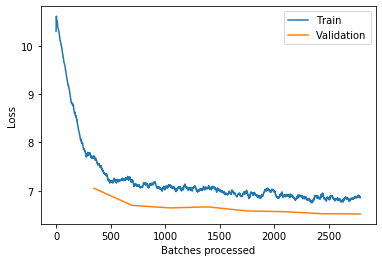

In [21]:
fig = cls_learn.recorder.plot_losses()
experiment.log_figure(figure_name="train loss 01", figure=fig)

In [47]:
cls_learn.unfreeze()

UN-FREEZING
Sequential(
  (0): Embedding(23008, 400, padding_idx=1)
  (1): EmbeddingDropout(
    (emb): Embedding(23008, 400, padding_idx=1)
  )
)
UN-FREEZING
Sequential(
  (0): WeightDropout(
    (module): LSTM(400, 1152, batch_first=True)
  )
  (1): RNNDropout()
)
UN-FREEZING
Sequential(
  (0): WeightDropout(
    (module): LSTM(1152, 1152, batch_first=True)
  )
  (1): RNNDropout()
)
UN-FREEZING
Sequential(
  (0): WeightDropout(
    (module): LSTM(1152, 400, batch_first=True)
  )
  (1): RNNDropout()
)
UN-FREEZING
Sequential(
  (0): Cls1Module400(
    (overall): Sequential(
      (0): BatchNorm1d(1200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Dropout(p=0.5, inplace=False)
      (2): Linear(in_features=1200, out_features=50, bias=True)
      (3): ReLU(inplace=True)
      (4): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): Linear(in_features=50, out_features=5, bias=True)
      (6): Softmax(dim=1)
    )
    (as

In [23]:
with experiment.train():
    cls_learn.fit_one_cycle(hyper_params["num_epochs2"])

epoch,train_loss,valid_loss,multi_acc,acc_0,acc_1,acc_2,acc_3,acc_4,acc_5,clas_mse0,clas_mse1,clas_mse2,clas_mse3,clas_mse4,clas_mse5,time
0,6.726648,6.499223,0.520950,0.614068,0.552554,0.478738,0.472051,0.491308,0.516983,0.539449,0.749398,0.979941,1.216635,0.965766,1.189890,01:42
1,6.718454,6.424824,0.525809,0.628510,0.555229,0.487029,0.469912,0.493180,0.520995,0.530891,0.793528,0.936882,1.228403,0.983151,1.169564,01:50
2,6.583037,6.297301,0.536908,0.642150,0.566194,0.500134,0.479540,0.507890,0.525542,0.479273,0.696175,0.907462,1.143354,0.873763,1.074084,01:48
3,6.468586,6.195272,0.547116,0.656593,0.579032,0.525809,0.480075,0.517518,0.523669,0.454934,0.671570,0.785504,1.171436,0.874565,1.137737,01:50
4,6.304110,6.108201,0.551663,0.664081,0.582776,0.522332,0.474726,0.518855,0.547205,0.442364,0.663011,0.839797,1.152447,0.843006,1.036373,01:41
5,6.184472,6.055491,0.556789,0.663011,0.584916,0.527949,0.487564,0.538112,0.539182,0.430596,0.637871,0.776946,1.110190,0.808237,1.002674,01:51
6,6.058676,6.002891,0.560533,0.674244,0.592404,0.526611,0.478470,0.536507,0.554961,0.420166,0.613800,0.797807,1.191228,0.838459,0.969778,01:45
7,6.022640,5.998025,0.562450,0.663279,0.592137,0.535972,0.480877,0.548007,0.554426,0.442899,0.617812,0.738968,1.132923,0.750735,0.943568,01:48
8,5.931955,5.977903,0.564679,0.667291,0.594009,0.550415,0.477668,0.546135,0.552554,0.426852,0.615405,0.723455,1.184274,0.755550,0.948114,01:41
9,5.870820,5.954693,0.566016,0.668361,0.592672,0.548007,0.483284,0.546135,0.557636,0.421236,0.601765,0.724793,1.116876,0.760899,0.912543,01:42


{'web': 'https://www.comet.ml/api/image/download?imageId=761e2fb030c340858eed24b48ae3879e&experimentKey=c861f55842994ac6ad68636707c48dad',
 'api': 'https://www.comet.ml/api/rest/v1/image/get-image?imageId=761e2fb030c340858eed24b48ae3879e&experimentKey=c861f55842994ac6ad68636707c48dad',
 'imageId': '761e2fb030c340858eed24b48ae3879e'}

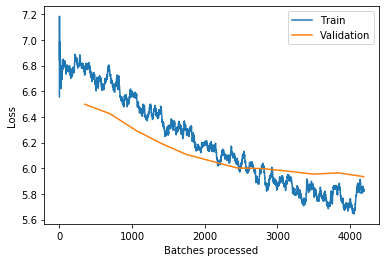

In [24]:
cls_learn.recorder.plot_losses()
experiment.log_figure(figure_name="train loss 02", figure=fig)

In [25]:
cls_learn.save('base01.class.learner.200102.2')

## CLAS 01

In [20]:
with experiment.train():
    cls_learn.fit_one_cycle(hyper_params["num_epochs1"])

epoch,train_loss,valid_loss,multi_acc,acc_0,acc_1,acc_2,acc_3,acc_4,acc_5,clas_mse0,clas_mse1,clas_mse2,clas_mse3,clas_mse4,clas_mse5,time
0,8.121052,7.712978,0.473745,0.552287,0.492110,0.439155,0.419631,0.468574,0.470714,0.790318,1.025675,1.208077,1.617545,1.289115,1.282963,01:36
1,7.737512,7.600085,0.486761,0.569404,0.516716,0.451190,0.415352,0.472051,0.495854,0.757689,0.946242,1.142017,1.454934,1.178925,1.288045,01:41
2,7.788678,7.648784,0.488366,0.575288,0.516983,0.447981,0.426852,0.470714,0.492378,0.696175,0.984220,1.228938,1.630382,1.300348,1.313185,01:42
3,7.603811,7.442239,0.493492,0.561915,0.527681,0.470179,0.431399,0.468842,0.500936,0.682268,0.922172,1.137737,1.584648,1.274672,1.289382,01:37
4,7.631531,7.495069,0.483686,0.577427,0.501204,0.457342,0.423108,0.453597,0.489436,0.621289,0.905590,1.066863,1.313720,1.121690,1.132388,01:39
5,7.569921,7.330184,0.492467,0.598021,0.516448,0.476063,0.408665,0.462958,0.492645,0.598288,0.793260,0.943568,1.320941,1.061514,1.071677,01:40
6,7.477180,7.247372,0.506107,0.588125,0.542124,0.477133,0.442097,0.488633,0.498529,0.654720,0.774539,0.989034,1.314790,1.059642,1.087457,01:40
7,7.464828,7.338844,0.501248,0.591067,0.525007,0.463493,0.443167,0.483284,0.501471,0.626906,0.951859,1.149505,1.506285,1.236962,1.284836,01:40
8,7.450336,7.268563,0.506820,0.595079,0.528216,0.462423,0.459481,0.486494,0.509227,0.598288,0.901043,1.167692,1.470982,1.196844,1.230543,01:41
9,7.362012,7.198591,0.511367,0.604975,0.538914,0.473121,0.455469,0.485691,0.510029,0.593742,0.821343,1.059909,1.365873,1.122225,1.163413,01:39


In [20]:
# using sent400
with experiment.train():
    cls_learn.fit_one_cycle(hyper_params["num_epochs1"], max_lr=slice(3e-4, 3e-3) )

epoch,train_loss,valid_loss,multi_acc,acc_0,acc_1,acc_2,acc_3,acc_4,acc_5,clas_mse0,clas_mse1,clas_mse2,clas_mse3,clas_mse4,clas_mse5,time
0,8.108837,7.755141,0.457520,0.555496,0.477668,0.427120,0.378978,0.443969,0.461888,0.771864,0.986093,1.214496,1.447981,1.208879,1.265579,00:52
1,7.821102,7.539276,0.476019,0.566194,0.518588,0.439957,0.395828,0.451725,0.483819,0.721583,0.992779,1.246590,1.707141,1.365606,1.359722,00:52
2,7.812713,7.741226,0.479406,0.578764,0.502541,0.429259,0.412142,0.461621,0.492110,0.716769,1.104841,1.326825,1.569136,1.301417,1.390746,00:50
3,7.840164,7.611420,0.485157,0.579834,0.500401,0.432736,0.434073,0.468040,0.495854,0.747526,1.071409,1.313185,1.641883,1.384595,1.421503,00:51
4,7.705922,7.334696,0.495988,0.584916,0.520995,0.457074,0.436213,0.475261,0.501471,0.611126,0.862263,1.123562,1.523134,1.181064,1.131586,00:55
5,7.708294,7.406851,0.494651,0.584381,0.514041,0.443969,0.431399,0.486494,0.507622,0.673175,0.965499,1.225996,1.564857,1.259963,1.211821,00:53
6,7.645872,7.359028,0.498083,0.597219,0.526879,0.456807,0.432201,0.470714,0.504680,0.614335,0.861728,1.133726,1.510029,1.188018,1.151377,00:55
7,7.471806,7.334513,0.497192,0.585986,0.518320,0.449585,0.439422,0.474726,0.515111,0.610859,0.957208,1.223857,1.540251,1.291522,1.232415,00:54
8,7.499104,7.422662,0.498039,0.587323,0.511634,0.450923,0.442632,0.483017,0.512704,0.603905,0.985290,1.232415,1.519658,1.275475,1.279754,00:54
9,7.533861,7.473027,0.501783,0.599358,0.520727,0.451725,0.439690,0.482749,0.516448,0.610324,0.968708,1.242578,1.587590,1.276277,1.274405,00:51


{'web': 'https://www.comet.ml/api/image/download?imageId=11b6413dc8834047bd1855255a4b20c4&experimentKey=6668a9eedab447e5ba900d0d12df5164',
 'api': 'https://www.comet.ml/api/rest/v1/image/get-image?imageId=11b6413dc8834047bd1855255a4b20c4&experimentKey=6668a9eedab447e5ba900d0d12df5164',
 'imageId': '11b6413dc8834047bd1855255a4b20c4'}

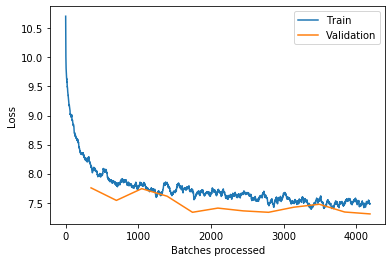

In [21]:
fig = cls_learn.recorder.plot_losses()
experiment.log_figure(figure_name="train loss 01", figure=fig)

In [22]:
cls_learn.save('clas01.class.learner.sent400epo12.200103.1')

In [48]:
cls_learn.load('clas01.class.learner.sent400epo12.200103.1')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (11173 items)
x: TextList
xxbos we had the most wonderful time at the excellence xxperiod we opted for the excellence club and it was well worht it for the perks xxperiod roberto puello who was the club manager did an extra special job of making us feel welcomed xxperiod we took some great pictures that looked like postcards xxperiod the food was excellent the pizza was close to being our favorite xxperiod the shows were great especially the michael jackson and the 70 's 80 's night xxperiod the french resturant was probably our favorite xxperiod we will definately be back for an anniversary trip xxperiod we made some friends but had plenty of xxunk as well xxperiod the rooms were great and everytime we left and came back it was cleaned , towels restocked and the bar was as well xxperiod,xxbos a truly fantastic place xmas we have just returned from a 2 week xmas new year break at the excellence punta cana xxperiod the hotel is magnif

In [49]:
cls_learn.unfreeze()

UN-FREEZING
Sequential(
  (0): Embedding(23008, 400, padding_idx=1)
  (1): EmbeddingDropout(
    (emb): Embedding(23008, 400, padding_idx=1)
  )
)
UN-FREEZING
Sequential(
  (0): WeightDropout(
    (module): LSTM(400, 1152, batch_first=True)
  )
  (1): RNNDropout()
)
UN-FREEZING
Sequential(
  (0): WeightDropout(
    (module): LSTM(1152, 1152, batch_first=True)
  )
  (1): RNNDropout()
)
UN-FREEZING
Sequential(
  (0): WeightDropout(
    (module): LSTM(1152, 400, batch_first=True)
  )
  (1): RNNDropout()
)
UN-FREEZING
Sequential(
  (0): Cls1Module400(
    (overall): Sequential(
      (0): BatchNorm1d(1200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Dropout(p=0.5, inplace=False)
      (2): Linear(in_features=1200, out_features=50, bias=True)
      (3): ReLU(inplace=True)
      (4): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): Linear(in_features=50, out_features=5, bias=True)
      (6): Softmax(dim=1)
    )
    (as

In [23]:
with experiment.train():
    cls_learn.fit_one_cycle(20)

epoch,train_loss,valid_loss,multi_acc,acc_0,acc_1,acc_2,acc_3,acc_4,acc_5,clas_mse0,clas_mse1,clas_mse2,clas_mse3,clas_mse4,clas_mse5,time
0,7.296806,7.148078,0.513194,0.610056,0.542124,0.472586,0.453330,0.490238,0.510832,0.584648,0.811982,1.041188,1.312918,1.092271,1.147633,04:15
1,7.213701,7.136572,0.516047,0.612998,0.550147,0.484354,0.448783,0.491040,0.508960,0.566194,0.768120,1.016315,1.331105,1.077828,1.119016,04:11
2,7.239865,7.127420,0.516760,0.618347,0.543728,0.478470,0.458946,0.488633,0.512437,0.541856,0.807168,1.031024,1.402514,1.108585,1.128377,04:09
3,7.157702,7.096952,0.522020,0.614335,0.550949,0.489703,0.463493,0.495052,0.518588,0.549880,0.768387,1.012035,1.360257,1.054827,1.059374,04:21
4,7.154971,6.999509,0.525586,0.625836,0.560845,0.500669,0.455737,0.494785,0.515646,0.509495,0.727467,0.966836,1.397700,1.072479,1.062584,04:06
5,7.084689,7.063907,0.521708,0.615405,0.560310,0.504413,0.441829,0.487831,0.520460,0.512437,0.685745,0.887136,1.248195,0.971650,0.982081,04:25
6,7.023447,7.009531,0.532362,0.649639,0.551484,0.499331,0.458946,0.500936,0.533833,0.461086,0.802621,1.018989,1.593474,1.132656,1.093073,04:16
7,6.860434,6.955785,0.532228,0.651244,0.556031,0.509495,0.463760,0.493982,0.518855,0.475261,0.694571,0.899438,1.310243,0.969511,0.980744,04:09
8,6.821098,6.920996,0.533342,0.645627,0.562985,0.507622,0.453865,0.496657,0.533298,0.448516,0.698048,0.889810,1.260230,0.974325,1.003209,04:18
9,6.850064,7.062575,0.535125,0.650174,0.549880,0.502006,0.468307,0.511367,0.529018,0.479807,0.815726,0.949184,1.358652,1.006686,1.064456,04:16


In [50]:
# using sent400
with experiment.train():
    cls_learn.fit_one_cycle(30)

epoch,train_loss,valid_loss,multi_acc,acc_0,acc_1,acc_2,acc_3,acc_4,acc_5,clas_mse0,clas_mse1,clas_mse2,clas_mse3,clas_mse4,clas_mse5,time
0,7.786158,7.462796,0.496568,0.582776,0.512971,0.450120,0.434876,0.485424,0.513239,0.641615,0.950254,1.198984,1.458144,1.206740,1.187751,01:47
1,7.688799,7.479429,0.499287,0.598556,0.519390,0.450120,0.436748,0.480075,0.510832,0.624766,0.973522,1.235892,1.502273,1.257021,1.227066,01:53
2,7.640443,7.441380,0.503254,0.598288,0.520995,0.450655,0.442097,0.489971,0.517518,0.640813,0.929660,1.183739,1.482214,1.192297,1.173843,01:51
3,7.757282,7.472091,0.494071,0.587858,0.506553,0.439422,0.441027,0.480342,0.509227,0.596416,1.027815,1.285370,1.607382,1.305429,1.285370,01:55
4,7.742739,7.543526,0.496434,0.593474,0.512437,0.443969,0.436748,0.486761,0.505215,0.623964,1.007489,1.261032,1.552822,1.236694,1.272533,01:58
5,7.633595,7.392751,0.500624,0.579032,0.519925,0.461621,0.446911,0.483552,0.512704,0.634662,0.932870,1.179995,1.580637,1.271730,1.231880,01:57
6,7.694147,7.269168,0.504725,0.598021,0.534635,0.468574,0.426585,0.483017,0.517518,0.592939,0.854507,1.108853,1.515913,1.196844,1.174646,01:55
7,7.590518,7.553910,0.496746,0.595614,0.512437,0.453330,0.434876,0.472586,0.511634,0.576892,0.985558,1.223589,1.520995,1.277079,1.256486,01:54
8,7.560078,7.876630,0.489569,0.589997,0.496924,0.436748,0.435945,0.475528,0.502273,0.638139,1.108318,1.337256,1.645360,1.386199,1.335919,01:54
9,7.533679,7.372339,0.503299,0.620219,0.510297,0.447713,0.441829,0.492378,0.507355,0.530623,0.977267,1.207275,1.573950,1.222519,1.209147,01:51


{'web': 'https://www.comet.ml/api/image/download?imageId=f4c2bba221dd41e785d0fbb38258e963&experimentKey=32d40a99344e48b689d6c6240c933c09',
 'api': 'https://www.comet.ml/api/rest/v1/image/get-image?imageId=f4c2bba221dd41e785d0fbb38258e963&experimentKey=32d40a99344e48b689d6c6240c933c09',
 'imageId': 'f4c2bba221dd41e785d0fbb38258e963'}

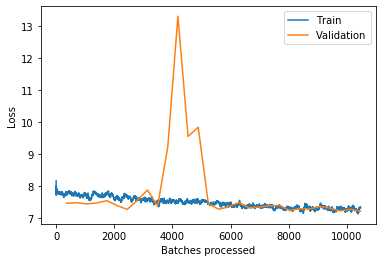

In [51]:
cls_learn.recorder.plot_losses()
experiment.log_figure(figure_name="train loss 02", figure=fig)

In [41]:
experiment.add_tag("Sigm")

In [42]:
cls_learn.save('clas01.class.learner.lowLR.200103.2')

## REGR 01

In [20]:
with experiment.train():
    cls_learn.fit_one_cycle(hyper_params["num_epochs1"])

epoch,train_loss,valid_loss,mse_0,mse_1,mse_2,mse_3,mse_4,mse_5,multi_regr_acc,regr_acc0,regr_acc1,regr_acc2,regr_acc3,regr_acc4,regr_acc5,time
0,6.918314,5.318137,0.760882,0.784878,0.846248,1.036169,0.894724,0.995238,0.399661,0.433003,0.445039,0.414014,0.265846,0.342070,0.397700,01:44
1,5.598637,4.893555,0.564469,0.736182,0.816203,1.007366,0.866276,0.903058,0.457163,0.516716,0.515913,0.481145,0.280556,0.445574,0.469644,01:43
2,5.329746,4.499112,0.484033,0.680830,0.783671,0.938388,0.769219,0.842971,0.471249,0.532495,0.548007,0.462156,0.284301,0.403584,0.468307,01:41
3,5.030967,4.448998,0.501068,0.676945,0.733243,0.941980,0.757807,0.837955,0.476108,0.550949,0.546403,0.483284,0.287510,0.436748,0.498262,01:43
4,4.862262,4.444495,0.544047,0.716060,0.721153,0.912195,0.731214,0.819826,0.440983,0.534635,0.487564,0.429794,0.279487,0.389141,0.435678,01:42
5,4.816375,4.323479,0.518021,0.676121,0.704813,0.903192,0.725731,0.795600,0.460818,0.534635,0.518053,0.451993,0.290987,0.399037,0.458144,01:41
6,4.857069,4.219900,0.477644,0.656627,0.693910,0.893325,0.715415,0.782977,0.471695,0.532763,0.539182,0.458946,0.289650,0.415352,0.468040,01:46
7,4.807860,4.205840,0.462178,0.649671,0.697231,0.890254,0.722065,0.784442,0.482705,0.553891,0.557368,0.473389,0.296336,0.428724,0.482749,01:45


{'web': 'https://www.comet.ml/api/image/download?imageId=657208724b184529aa8d58c894353ee5&experimentKey=0940d41d0c1e4e4e9c999b97b3dc1c81',
 'api': 'https://www.comet.ml/api/rest/v1/image/get-image?imageId=657208724b184529aa8d58c894353ee5&experimentKey=0940d41d0c1e4e4e9c999b97b3dc1c81',
 'imageId': '657208724b184529aa8d58c894353ee5'}

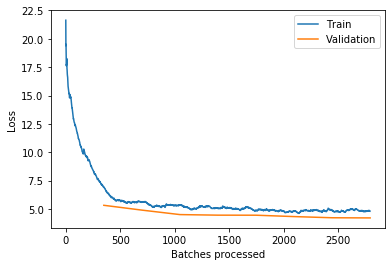

In [21]:
fig = cls_learn.recorder.plot_losses()
experiment.log_figure(figure_name="train loss 01", figure=fig)

In [22]:
cls_learn.save('cls_learn.REGR1.DOCPOLL4ALL.200101')

In [26]:
# cls_learn.load('cls_learn.1200CLS2.191202')

In [23]:
cls_learn.unfreeze()

UN-FREEZING
Sequential(
  (0): Embedding(23008, 400, padding_idx=1)
  (1): EmbeddingDropout(
    (emb): Embedding(23008, 400, padding_idx=1)
  )
)
UN-FREEZING
Sequential(
  (0): WeightDropout(
    (module): LSTM(400, 1152, batch_first=True)
  )
  (1): RNNDropout()
)
UN-FREEZING
Sequential(
  (0): WeightDropout(
    (module): LSTM(1152, 1152, batch_first=True)
  )
  (1): RNNDropout()
)
UN-FREEZING
Sequential(
  (0): WeightDropout(
    (module): LSTM(1152, 400, batch_first=True)
  )
  (1): RNNDropout()
)
UN-FREEZING
Sequential(
  (0): Regr1Module1200(
    (overall): Sequential(
      (0): BatchNorm1d(1200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Dropout(p=0.5, inplace=False)
      (2): Linear(in_features=1200, out_features=50, bias=True)
      (3): ReLU(inplace=True)
      (4): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): Linear(in_features=50, out_features=1, bias=True)
    )
    (aspect): Sequential(
     

In [24]:
with experiment.train():
    cls_learn.fit_one_cycle(hyper_params["num_epochs2"])

epoch,train_loss,valid_loss,mse_0,mse_1,mse_2,mse_3,mse_4,mse_5,multi_regr_acc,regr_acc0,regr_acc1,regr_acc2,regr_acc3,regr_acc4,regr_acc5,time
0,4.799436,4.260633,0.457997,0.656352,0.710068,0.913200,0.735312,0.787705,0.485290,0.541054,0.554694,0.465900,0.278952,0.408933,0.473121,04:15
1,4.417687,4.082174,0.448406,0.631651,0.680468,0.860865,0.702469,0.758315,0.486806,0.569404,0.541321,0.470447,0.304894,0.397165,0.463760,04:11
2,4.402441,3.951401,0.409222,0.597708,0.645708,0.868459,0.686118,0.744185,0.499733,0.578497,0.570473,0.470179,0.303557,0.406258,0.501471,04:14
3,4.162312,3.898916,0.371607,0.576505,0.646734,0.873216,0.685574,0.745279,0.515646,0.600695,0.579567,0.489168,0.313720,0.395293,0.465365,04:16
4,3.866946,3.827533,0.389891,0.559167,0.649768,0.839925,0.670435,0.718347,0.516716,0.568066,0.600160,0.494785,0.323348,0.464830,0.527949,04:19
5,3.784092,3.798485,0.349788,0.568773,0.643759,0.830500,0.669239,0.736426,0.531024,0.638673,0.595881,0.490773,0.323081,0.426050,0.482749,04:21
6,3.645323,3.646075,0.350809,0.545268,0.605300,0.804737,0.649145,0.690816,0.529776,0.635197,0.605777,0.493715,0.334314,0.463493,0.511634,04:18
7,3.572599,3.677935,0.343300,0.549174,0.618993,0.823154,0.642459,0.700855,0.530891,0.625301,0.612731,0.481680,0.320674,0.430864,0.504146,04:24
8,3.485589,3.632818,0.332642,0.529108,0.615968,0.817624,0.643289,0.694186,0.540296,0.640546,0.622091,0.504680,0.327895,0.443434,0.508960,04:20
9,3.329951,3.606784,0.360438,0.525102,0.595009,0.805714,0.636025,0.684498,0.535616,0.630115,0.613266,0.497192,0.335384,0.449318,0.521797,04:27


{'web': 'https://www.comet.ml/api/image/download?imageId=43ea27c68d2a4011be3205614e1db743&experimentKey=0940d41d0c1e4e4e9c999b97b3dc1c81',
 'api': 'https://www.comet.ml/api/rest/v1/image/get-image?imageId=43ea27c68d2a4011be3205614e1db743&experimentKey=0940d41d0c1e4e4e9c999b97b3dc1c81',
 'imageId': '43ea27c68d2a4011be3205614e1db743'}

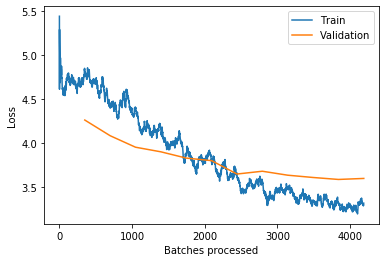

In [25]:
cls_learn.recorder.plot_losses()
experiment.log_figure(figure_name="train loss 02", figure=fig)

In [26]:
cls_learn.save('cls_learn.REGR1.DOCPOLL4ALL.200101.2')

In [32]:
#cls_learn.load('cls_learn.REGR1.200101.2')

# FINISH EXPR

In [64]:
experiment.end()

COMET INFO: ----------------------------
COMET INFO: Comet.ml Experiment Summary:
COMET INFO:   Data:
COMET INFO:     url: https://www.comet.ml/aeryen/2019nn/32d40a99344e48b689d6c6240c933c09
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     sys.cpu.percent.01 [43]             : (2.8, 13.3)
COMET INFO:     sys.cpu.percent.02 [43]             : (2.1, 20.2)
COMET INFO:     sys.cpu.percent.03 [43]             : (2.7, 9.6)
COMET INFO:     sys.cpu.percent.04 [43]             : (1.8, 10.5)
COMET INFO:     sys.cpu.percent.05 [43]             : (2.0, 22.8)
COMET INFO:     sys.cpu.percent.06 [43]             : (1.9, 8.4)
COMET INFO:     sys.cpu.percent.07 [43]             : (1.8, 5.3)
COMET INFO:     sys.cpu.percent.08 [43]             : (1.8, 9.3)
COMET INFO:     sys.cpu.percent.09 [43]             : (1.7, 16.4)
COMET INFO:     sys.cpu.percent.10 [43]             : (2.0, 9.7)
COMET INFO:     sys.cpu.percent.11 [43]             : (1.6, 7.4)
COMET INFO:     sys.cpu.percent.12 [43]        

# Test output

In [52]:
def get_preds(self, ds_type:DatasetType=DatasetType.Valid, activ:nn.Module=None, with_loss:bool=False, n_batch:Optional[int]=None,
              pbar:Optional[PBar]=None, ordered:bool=False) -> List[Tensor]:
    "Return predictions and targets on the valid, train, or test set, depending on `ds_type`."
    self.model.reset()
    if ordered: np.random.seed(42)
    
    with torch.no_grad():
        outs = []
        asps = []
        rats = []
        text = []
        truth = []
        for xb,yb in progress_bar(cls_learn.dl(DatasetType.Valid)):
            out,raw_enc,enc,asp,rat = cls_learn.model(xb)
    #         text.append(xb)
            truth.append(yb)
            outs.append(out)
            for doc in asp:
                asps.append( to_float(doc.cpu()))
            for doc in rat:
                rats.extend( to_float(doc.cpu()) )

    # text = to_float(torch.cat(text).cpu())
    truth = to_float(torch.cat(truth).cpu())
    outs = to_float(torch.cat(outs).cpu())
    
    if ordered and hasattr(self.dl(ds_type), 'sampler'):
        np.random.seed(42)
        sampler = [i for i in self.dl(ds_type).sampler]
        reverse_sampler = np.argsort(sampler)
        
        truth = truth[reverse_sampler]
        outs = outs[reverse_sampler]
        
        asps = [asps[i] for i in reverse_sampler]
        rats = [rats[i] for i in reverse_sampler]
    return (truth,outs,asps,rats)

In [53]:
truth,outs,asps,rats = get_preds(self=cls_learn, ds_type=DatasetType.Valid, ordered=True)

In [31]:
#torch.argmax(asps[0],dim=1)

# load test text

In [54]:
sent_num_file = ["aspect_0.count", "test_aspect_0.count"]
rating_file = ["aspect_0.rating", "test_aspect_0.rating"]
content_file = ["aspect_0.txt", "test_aspect_0.txt"]

dataset_dir = "./data/hotel_balance_LengthFix1_3000per/"

In [55]:
def concat_to_doc(sent_list, sent_count):
    start_index = 0
    docs = []
    for s in sent_count:
#         doc = " xxPERIOD ".join(sent_list[start_index:start_index + s])
#         doc = doc + " xxPERIOD "
        docs.append(sent_list[start_index:start_index + s])
        start_index = start_index + s
    return docs

In [56]:
TRAIN_DATA = 0
TEST_DATA = 1

In [57]:
# Load Count
sent_count_test = list(open(dataset_dir + sent_num_file[TEST_DATA], "r").readlines())
sent_count_test = [int(s) for s in sent_count_test if (len(s) > 0 and s != "\n")]
print( sent_count_test[0:5] )

# Load Ratings
aspect_rating_test = list(open(dataset_dir + rating_file[TEST_DATA], "r").readlines())
aspect_rating_test = [s for s in aspect_rating_test if (len(s) > 0 and s != "\n")]

aspect_rating_test = [s.split(" ") for s in aspect_rating_test]
aspect_rating_test = np.array(aspect_rating_test)[:, 0:-1]
aspect_rating_test = aspect_rating_test.astype(np.int) - 1
aspect_rating_test = pd.DataFrame(aspect_rating_test)
print( aspect_rating_test.head() )

# Load Sents
sents_test = list(open(dataset_dir + content_file[TEST_DATA], "r").readlines())
sents_test = [s.strip() for s in sents_test]

# Sents to Doc
docs_test = concat_to_doc(sents_test, sent_count_test)

docs_test = pd.DataFrame({doc:docs_test})

[9, 30, 25, 33, 29]
   0  1  2  3  4  5
0  1  0  0  3  1  1
1  2  2  1  2  3  3
2  4  4  4  3  4  4
3  3  2  3  3  3  4
4  3  4  3  4  4  4


In [58]:
df_test = pd.concat( [aspect_rating_test, docs_test], axis=1, ignore_index=True )
df_test.head()

,0,1,2,3,4,5,6
0,1,0,0,3,1,1,[definitely not a 5 star resort i 'm dumbfound...
1,2,2,1,2,3,3,"[facilities need work, we visited excellence f..."
2,4,4,4,3,4,4,"[excellence was exactly that, my family and i ..."
3,3,2,3,3,3,4,"[great service , nice hotel , mediocre food, m..."
4,3,4,3,4,4,4,[very relaxing experience just returned from m...


# Visualize classification output

In [51]:
asp_inc_overall = False
if not asp_inc_overall: 
    nasp_analysis = hyper_params["num_aspect"] - 1
else:
    nasp_analysis = hyper_params["num_aspect"]
    
np.set_printoptions(precision=3)
asp_name = ["overall", "value", "room", "location", "clean", "service"]
for i in range(10):
    print("truth:")
    print(df_test.iloc[i,0:6].values.flatten().tolist() )
    print("prediction:")
    print( torch.argmax(outs[i][0:6],dim=1) )
    print("doc:")
    dasp = torch.argmax(asps[i][:,0:nasp_analysis],dim=1).numpy()
    if asp_inc_overall: dasp_noall = torch.argmax(asps[i][:,1:6],dim=1).numpy()
    dasp_dist = torch.nn.functional.softmax(asps[i][:,0:nasp_analysis], dim=1).numpy()
    for senti,s in enumerate(df_test.iloc[i,6]):
        print(s)
        if asp_inc_overall:
            print("          +++ "+ asp_name[dasp[senti]] + " +++ " + asp_name[dasp_noall[senti]+1] + " +++ " + str(dasp_dist[senti]) )
        else:
            print("          +++ "+ asp_name[dasp[senti]+1] + " +++ " + str(dasp_dist[senti]) )
    print("===========")

truth:
[1, 0, 0, 3, 1, 1]
prediction:
tensor([1, 0, 1, 2, 1, 0])
doc:
definitely not a 5 star resort i 'm dumbfounded that this hotel gets good reviews and is so highly rated
          +++ value +++ [0.215 0.19  0.184 0.212 0.2  ]
it 's decidedly a 3 star property , not 5 stars as indicated
          +++ value +++ [0.235 0.227 0.108 0.221 0.21 ]
the rooms are very dated and run down , old crappy beds and pillows , an old tv and overall poorly maintained
          +++ room +++ [0.25  0.269 0.099 0.269 0.114]
the whole property is pretty run down and old - looking
          +++ room +++ [0.245 0.274 0.101 0.274 0.106]
the food is subpar , not one meal i had would be called great
          +++ value +++ [0.258 0.24  0.1   0.256 0.145]
the service is uneven and the staff is poorly trained and uninformed
          +++ service +++ [0.242 0.133 0.131 0.138 0.356]
many do not comprehend english
          +++ service +++ [0.235 0.136 0.134 0.138 0.358]
the beach is great , it 's the only redeem

# Visualize regression output

In [35]:
asp_inc_overall = False
if not asp_inc_overall: 
    nasp_analysis = hyper_params["num_aspect"] - 1
else:
    nasp_analysis = hyper_params["num_aspect"]
    
np.set_printoptions(precision=3)
asp_name = ["overall", "value", "room", "location", "clean", "service"]
for i in range(10):
    print("truth:")
    print( df_test.iloc[i,0:6].values.flatten().tolist() )
    print("prediction:")
    print( outs[i][0:6] )
    print("doc:")
    dasp = torch.argmax(asps[i][:,0:nasp_analysis],dim=1).numpy()
    if asp_inc_overall: dasp_noall = torch.argmax(asps[i][:,1:6],dim=1).numpy()
    dasp_dist = torch.nn.functional.softmax(asps[i][:,0:nasp_analysis], dim=1).numpy()
#     dasp_dist = asps[i][:,0:nasp_analysis].numpy()
    for senti,s in enumerate(df_test.iloc[i,6]):
        print(s)
        if asp_inc_overall:
            print("          +++ "+ asp_name[dasp[senti]] + " +++ " + asp_name[dasp_noall[senti]+1] + " +++ " + str(dasp_dist[senti]) )
        else:
            print("          +++ "+ asp_name[dasp[senti]+1] + " +++ " + str( np.around(dasp_dist[senti], decimals=2) ) )
    print("===========")

truth:
[1, 0, 0, 3, 1, 1]
prediction:
tensor([ 0.7459,  0.4020, -0.0947,  2.4229,  0.3754,  0.2812])
doc:
definitely not a 5 star resort i 'm dumbfounded that this hotel gets good reviews and is so highly rated
          +++ location +++ [0.21 0.19 0.21 0.19 0.19]
it 's decidedly a 3 star property , not 5 stars as indicated
          +++ value +++ [0.21 0.2  0.2  0.2  0.2 ]
the rooms are very dated and run down , old crappy beds and pillows , an old tv and overall poorly maintained
          +++ room +++ [0.22 0.29 0.16 0.17 0.16]
the whole property is pretty run down and old - looking
          +++ value +++ [0.29 0.2  0.16 0.18 0.16]
the food is subpar , not one meal i had would be called great
          +++ value +++ [0.35 0.16 0.16 0.16 0.16]
the service is uneven and the staff is poorly trained and uninformed
          +++ service +++ [0.21 0.16 0.16 0.16 0.31]
many do not comprehend english
          +++ service +++ [0.21 0.18 0.18 0.18 0.26]
the beach is great , it 's the only r

# eval

In [59]:
def eval_hotel_asp(asp_pred, asp_true, asp_inc_overall):
    asp_to_id = {"value":0, "room":1, "location":2, "cleanliness":3, "service":4, "none":-1}
    asp_true = np.array( [asp_to_id[l] for l in asp_true] )
    print("total true: " + str(len(asp_true)) )
    print("total not none: " + str(sum(asp_true>0)) )
    
    asp_pred_index = []
    if asp_inc_overall:
        for i in range(1000):
            asp_pred_index.append( asp_pred[i][:,1:6].numpy().argsort() )
    else:
        for i in range(1000):
            asp_pred_index.append( asp_pred[i][:,0:5].numpy().argsort() )
    asp_pred_index = np.concatenate( asp_pred_index , axis=0)
    
    result_index = []
    for i,lbl in enumerate(asp_true):
        if(lbl==-1):
            result_index.append(-1)
        else:
            at = np.where(asp_pred_index[i,] == lbl)
            result_index.append(at[0][0])
    result_index = np.array(result_index)
    
    print("Top 1 ACC:")
    print( sum(result_index>=4) / sum(result_index>=0) )
    print("Top 2 ACC:")
    print( sum(result_index>=3) / sum(result_index>=0) )

In [60]:
yifan_label = open(dataset_dir + "test_aspect_0.yifan.aspect", "r").readlines()
yifan_label = [s.split()[0] for s in yifan_label]

In [61]:
eval_hotel_asp(asps, yifan_label, asp_inc_overall=False)

total true: 502
total not none: 242
Top 1 ACC:
0.4505928853754941
Top 2 ACC:
0.6007905138339921


In [62]:
fan_label = open(dataset_dir + "test_aspect_0.fan.aspect", "r").readlines()
fan_label = [s.split()[0] for s in fan_label]

In [63]:
eval_hotel_asp(asps, fan_label, asp_inc_overall=False)

total true: 621
total not none: 288
Top 1 ACC:
0.5073746312684366
Top 2 ACC:
0.6519174041297935
